In [4]:
import spacy
import spacy_transformers
from spacy.matcher import Matcher
import networkx as nx
import stanza
import spacy_stanza
from spacy.pipeline import merge_entities
from itertools import combinations
import csv
import datetime

## Shortest path with Spacy

In [5]:
nlp = spacy_stanza.load_pipeline("en", verbose=False)
nlp.add_pipe("merge_entities")
# nlp.add_pipe("merge_noun_chunks")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [6]:
# nlp = spacy.load("en_core_web_trf", disable=["textcat"])
# nlp.add_pipe("merge_entities")

In [14]:
sample_sentences = [
    'Robots in popular culture are there to remind us of the awesomeness of unbound human agency.',
    "Amsterdam is the capital and largest city in the European country of the Netherlands.",
    "Amsterdam is refered to as the 'Venice of the North'.",
    "Located in North-Holland, Amsterdam is the capital of the Netherlands.",
    "The city hosts two universities (Vrije University and University of Amsterdam) and an international airport 'Schiphol Airport' built in 1923.",
    "Winehouse effortlessly performed her song Rehab",
    "Google will join Meta and Amazon.",
    "Elon Musk founded Tesla and Bill Gates founded Microsoft.",
    "Google joined other tech compnaies like Mcsoft and Amazon.",
    "Michael is a parent of James.",
    "The Obama administration is offering only modest greenhouse gas reduction targets at the conference.",
    "Amsterdam Building is in the Netherlands.",
    "The only diplomatic offices present in Amsterdam are consulates.",
    "Unlike in capitals of most other countries, the national government, parliament, government ministries, supreme court, royal family and embassies are not in Amsterdam, but in The Hague. ",
    "WP Cumulus Flash tag cloud by Roy Tanck and Luke Morton requires Flash Player 9 or better."
]

In [17]:
document = nlp(sample_sentences[1])

print(document)

edges = []
for token in document:
    for child in token.children:
        edges.append((token, child))

graph = nx.Graph(edges)

Amsterdam is the capital and largest city in the European country of the Netherlands.


In [18]:
for i, token in enumerate(document):
    print(f"{i:2} - {token.text:30} {token.pos_:10} {token.tag_:10} {token.dep_:10}")

 0 - Amsterdam                      PROPN      NNP        nsubj     
 1 - is                             AUX        VBZ        cop       
 2 - the                            DET        DT         det       
 3 - capital                        NOUN       NN         root      
 4 - and                            CCONJ      CC         cc        
 5 - largest                        ADJ        JJS        amod      
 6 - city                           NOUN       NN         conj      
 7 - in                             ADP        IN         case      
 8 - the                            DET        DT         det       
 9 - European                       ADJ        JJ         amod      
10 - country                        NOUN       NN         nmod      
11 - of                             ADP        IN         case      
12 - the                            DET        DT         det       
13 - Netherlands                    PROPN      NNPS       nmod      
14 - .                            

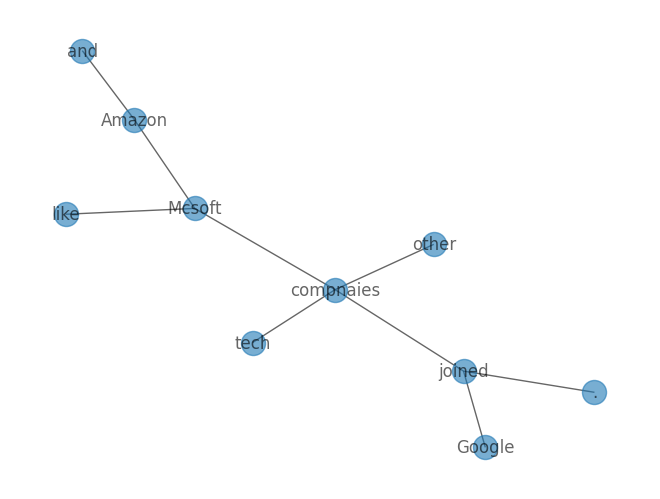

In [10]:
nx.draw(graph, with_labels = True, alpha=0.6, )

In [16]:
no_pos = {"AUX"}
no_dep = set()
no_dep = {"dobj", 'nsubj', 'probj', 'conj'}

def extract_relations_1(doc):
    relations = []
    ents = doc.ents
    ents_pairs = [(e1, e2) for e1, e2 in list(combinations(ents, 2))]
#     ents_pairs = [(e1, e2) for e1, e2 in list(combinations(ents, 2)) if (ents.index(e1) - ents.index(e2) < 3)]
    edges = []
    
    for token in doc:
        for child in token.children:
            edges.append((token, child))
    graph = nx.Graph(edges)
    
    for e1, e2 in ents_pairs:
        verb, noun = 0, 0
        path = nx.shortest_path(graph, source=doc[e1.start-doc.start], target=doc[e2.start-doc.start])
#         print('+', path)
        path = path[1:-1]
#         print(e1, ',', e2)
#         print([(t.text, t.pos_, t.dep_) for t in path])
        for t in path:
            if t.pos_ == "VERB":
                verb += 1
            elif t.pos_ in {"NOUN", "PROPN"}:
                noun += 1
        if verb > 1 or noun > 1 or (len(path) == noun):
            continue
        path = [t for t in path if t.pos_ not in no_pos 
                                and not t.ent_type 
                                and not (t.pos_ == "NOUN" and t.dep_ in no_dep)]
        
        if not len(path):
            continue
        if path[0].dep_ == "prep":
            path = path[::-1]
        relations.append((e1, ' '.join([t.text for t in path]).lower(), e2))
    return relations

In [17]:
%%time
a = 0
for sentence in sample_sentences:
    s = [s for s in nlp(sentence).sents][0]
    rs = extract_relations_1(s)
    a += len(rs)
    for e1, r, e2 in rs:
        print(f"{e1} - {r} - {e2}")

Amsterdam - refered - the 'Venice of the North'
North-Holland - located capital - Amsterdam
North-Holland - located capital - Netherlands
'Schiphol Airport' - built - 1923
Winehouse - performed - Rehab
Google - join - Meta
Google - join - Amazon
Elon Musk - founded - Tesla
Elon Musk - founded - Bill Gates
Google - joined compnaies - Msoft
WP Cumulus Flash - requires - Flash Player 9
Roy Tanck - requires - Flash Player 9
CPU times: user 5.73 s, sys: 417 ms, total: 6.14 s
Wall time: 5.52 s


In [10]:
pattern = [
[
    {"POS": "VERB"},
    {"POS": "PART", "OP": "?"},
    {"POS": "ADV",  "OP": "?"},
    {"POS": {"IN": ["ADJ", "ADV", "PRON", "DET"]}, "OP": "*"},
    {"POS": {"IN": ["PART", "ADP"]}, "OP": "?"}    
],
[
    {"POS": "NOUN"},
    {"DEP": "prep"}    
]
]
matcher = Matcher(nlp.vocab)
matcher.add("pattern", pattern)

In [11]:
no_pos = {"AUX"}
# no_dep = {"dobj", 'nsubj', 'probj', 'conj'}
no_dep = set()

def extract_relations_2(doc):
    relations = []
    ents = doc.ents
    ents_pairs = [(e1, e2) for e1, e2 in list(combinations(ents, 2))]
    ents_pairs = [(e1, e2) for e1, e2 in list(combinations(ents, 2)) if (ents.index(e1) - ents.index(e2) < 3)]
    edges = []
    
    for token in doc:
        for child in token.children:
            edges.append((token, child))
    graph = nx.Graph(edges)
    
    for e1, e2 in ents_pairs:
        verb, noun = 0, 0
        path = nx.shortest_path(graph, source=doc[e1.start-doc.start], target=doc[e2.start-doc.start])
        path = path[1:-1]
        
        if not len(path):
            continue
        
        for t in path:
            if t.pos_ == "VERB":
                verb += 1
            elif t.pos_ == "NOUN":
                noun += 1
        if verb > 1 or noun > 1:
            continue
        
        if path[0].dep_ == "prep":
            path = path[::-1] 
            
        path_string = ' '.join([t.text for t in path])
        path_doc = nlp(path_string)
#         print(e1, ',', e2)
#         print([(t.text, t.pos_, t.dep_) for t in path_doc])
        matches = matcher(path_doc)
        spans = [path_doc[start:end] for _, start, end in matches]
#         print(spans)
        spans = spacy.util.filter_spans(spans)
#         print(path_string)
#         print(spans)
#         if len(spans):
#             print(f"-> {e1} - {spans[0]} - {e2}")
        if len(spans) > 0:
            relations.append((e1, spans[0], e2))
#         print('-'*10)
    return relations

In [167]:
%%time
for sentence in sample_sentences:
    s = [s for s in nlp(sentence).sents][0]
    rs = extract_relations_2(s)
    for e1, r, e2 in rs:
        print(f"{e1} - {r} - {e2}")

European - country of - Netherlands
Amsterdam - refered as - the 'Venice of the North
North-Holland - Located in - Amsterdam
North-Holland - Located in - Netherlands
Amsterdam - capital of - Netherlands
'Schiphol Airport' - built in - 1923
Winehouse - performed - Rehab
Google - join - Meta
Google - join - Amazon
Elon Musk - founded - Tesla
Bill Gates - founded - Microsoft
Google - joined - Msoft
Google - joined - Ama
Michael - parent of - James
WP - cloud by - Roy Tanck
WP - cloud by - Luke Morton
WP - requires - Flash Player 9
Cumulus - cloud by - Roy Tanck
Cumulus - cloud by - Luke Morton
Cumulus - requires - Flash Player 9
Roy Tanck - requires - Flash Player 9
Luke Morton - requires - Flash Player 9
CPU times: user 1.37 s, sys: 345 ms, total: 1.72 s
Wall time: 1.51 s


In [169]:
%%time
filename = "pre-proc/warcs-20221210-141217.csv"
rows = []

with open(filename, newline='') as file:
    csv_reader = csv.reader(file, quoting=csv.QUOTE_NONE, escapechar='\\')
    c = 0
    for row in csv_reader:
        document = nlp(row[-1])
        sentences = [s for s in document.sents]
        for sentence in sentences:
            relations = extract_relations_2(sentence)
            for e1, r, e2 in relations:
                rows.append((row[0], sentence, f"{e1}-{r}-{e2}"))
        if (c := c + 1) % 20 == 0:
            print(c)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220


Token indices sequence length is longer than the specified maximum sequence length for this model (531 > 512). Running this sequence through the model will result in indexing errors


1240
1260
1280
1300
1320
1340
1360
CPU times: user 29min 25s, sys: 3min 27s, total: 32min 52s
Wall time: 19min 13s


In [171]:
filename = f'relation-patty-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
res_directory = "relations"

with open(f"{res_directory}/{filename}.csv", 'w', newline='', encoding='UTF-8') as file:
        writer = csv.writer(file)
        writer.writerows([row for row in rows])